#### Simulation

##### Import

In [22]:

import numpy as np
import itertools
import requests
import polyline
import json
import os

import random as rd
import pandas as pd

from shapely.geometry import Point

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import warnings 

warnings.filterwarnings('ignore')

##### 좌표 거리 생성 함수

In [23]:
# 직선 거리 게산 함수
def calculate_straight_distance(lat1, lon1, lat2, lon2):
    # 지구 반경 (킬로미터 단위)
    km_constant = 3959* 1.609344
    # 위도와 경도를 라디안으로 변환
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    # 위도 및 경도 차이 계산
    dlat = lat2 - lat1 
    dlon = lon2 - lon1
    # Haversine 공식 계산
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    # 거리 계산 (킬로미터 단위)
    km = km_constant * c
    
    return km

##### trips 데이터 생성 함수

In [24]:
#### osrm 페키지로 경로 추출
# 입력으로 받은 출발지와 목적지 좌표를 이용하여 경로 정보를 가져오는 함수
def get_res(point):

   status = 'defined'

   # 요청을 재시도할 수 있도록 세션 객체 생성 및 설정
   session = requests.Session()
   retry = Retry(connect=3, backoff_factor=0.5)
   adapter = HTTPAdapter(max_retries=retry)
   session.mount('http://', adapter)
   session.mount('https://', adapter)

   #### url 생성 코드
   # 전체 경로 정보를 요청
   overview = '?overview=full'
   # lon, lat, lon, lat 형식의 출발지 목적지 좌표
   loc = f"{point[0]},{point[1]};{point[2]},{point[3]}"
   # 보행경로 url
   url = 'http://router.project-osrm.org/route/v1/foot/'
   # 경로 정보 요청
   r = session.get(url + loc + overview) 
   
   # 만약 경로가 안뜰 때 대체 결과 생성
   if r.status_code!= 200:
      
      status = 'undefined'
      
       # 직선 거리 계산
      distance = calculate_straight_distance(point[1], point[0], point[3], point[2]) * 1000
      
      # 경로 정보 생성 (출발지와 목적지 좌표만 포함)
      route = [[point[0], point[1]], [point[2], point[3]]]

      # 소요 시간 및 타임스탬프 계산 (가정: 보행 속도 10km/h)
      speed_km = 10#km
      speed = (speed_km * 1000/60)      
      duration = distance/speed
      
      timestamp = [0, duration]

      result = {'route': route, 'timestamp': timestamp, 'duration': duration, 'distance' : distance}
   
      return result, status
   
   # 경로 정보를 성공적으로 가져온 경우, JSON 응답을 반환
   res = r.json()   
   return res, status

In [25]:
# 경로를 가는데 걸리는 시간과 거리 추출 함수
def extract_duration_distance(res):
   # get_res함수에서 추출된 데이터에서 시간과 거리 뽑기
   
   duration = res['routes'][0]['duration']/(60)  # 분 단위로 변환
   distance = res['routes'][0]['distance']
   
   return duration, distance

# 경로 추출 함수
def extract_route(res):
   
    # get_res함수에서 추출된 데이터에서 경로 뽑기
    # 경로가 인코딩 되어 있기 때문에 아래 함수를 써서 디코딩해주어야지 위경도로 이루어진 경로가 나옴
    route = polyline.decode(res['routes'][0]['geometry'])
    
    # 사용할 형식에 맞춰 위경도 좌표의 위치를 바꿔주는 것
    route = list(map(lambda data: [data[1],data[0]] ,route))
    
    return route

In [26]:
# 총 걸리는 시간을 경로의 거리 기준으로 쪼개주는 함수
def extract_timestamp(route, duration):
    
    # 리스트를 numpy이 배열로 변경
    rt = np.array(route)
    # 리스트를 수평 기준으로 합치기
    rt = np.hstack([rt[:-1,:], rt[1:,:]])
    # 각각 직선거리 추출(리스트 형태)
    per = calculate_straight_distance(rt[:,1], rt[:,0], rt[:,3], rt[:,2])
    # 각각의 직선거리를 전체 직선거리의 합으로 나누기
    per = per / np.sum(per)

    # 계산된 비율을 기반으로 각 지점 도착 예상 시간 계산
    timestamp = per * duration
    timestamp = np.hstack([np.array([0]),timestamp])
    timestamp = list(itertools.accumulate(timestamp)) 
    
    return timestamp

In [27]:
# 모든 함수를 한번에 실행하는 코드(trips 데이터의 형태로 저장)
def osrm_routing_machine(O, D):

   # osrm 데이터 생성
   osrm_base, status = get_res([O.x, O.y, D.x, D.y])
   
   # osrm 데이터가 생성 됬으면 진행
   if status == 'defined':
      # 거리 및 걸리는 시간 추출
      duration, distance = extract_duration_distance(osrm_base)
      # 경로 추출
      route = extract_route(osrm_base)
      # timestamp 생성
      timestamp = extract_timestamp(route, duration)
      # 결과 저장
      result = {'route': route, 'timestamp': timestamp, 'duration': duration, 'distance' : distance}
      
      return result
   else: 
      return osrm_base
# OD_data 한쌍일 때 osrm_routing_machine작동함수
def osrm_routing_machine_multiprocess(OD):
   O, D = OD
   result = osrm_routing_machine(O, D)
   return result
# OD_data 데이터가 리스트쌍 일때의 osrm_routing_machine 작동함수
def osrm_routing_machine_multiprocess_all(OD_data):
    results = list(map(osrm_routing_machine_multiprocess, OD_data))
    return results

##### od 데이터 생성

In [28]:
# 랜덤한 쌍의 od 데이터(시작점과 도착점이 같이 않게 뜸)
def get_OD_data(point, num = 10) :
    random_pairs = []

    # 10개의 랜덤쌍 좌표 생성
    for _ in range(num):
        # 포인트 좌표의 key값을 이용하여 래덤 쌍 생성
        neighborhood1, neighborhood2 = rd.sample(point.keys(), 2)
        # 랜덤쌍의 첫번째 값을 시작점으로 두번째 값을 도착점으로 설정
        start_point = point[neighborhood1]
        end_point = point[neighborhood2]
        # 시작점과 출발점을 리스트로 만들어 리스트에 추가
        random_pairs.append([start_point, end_point])

    OD_data = []
    
    # random_pairs를 이용해서 od 데이터 생성
    for i, (start_point, end_point) in enumerate(random_pairs, 1):
        OD_data.append({
            # 포인트 좌표의 key값을 이용해서 od좌표의 이름을 생성
            "O_name": list(point.keys())[list(point.values()).index(start_point)],
            # random_pairs를 이용해서 좌표 설정
            "O": Point(start_point),
            "D_name": list(point.keys() )[list(point.values()).index(end_point)],
            "D": Point(end_point)
        })
        
    OD_data = pd.DataFrame(OD_data)
    
    return OD_data

In [29]:
# 데이터 좌표
# point = {
    # "가천대역" : [127.126858, 37.449621],
    # "가천대_반도체대학" : [127.127384 , 37.450910],
    # "가천대_일반대학원" : [127.130112 , 37.452589],
    # "가천대_교육대학원" : [127.131698 , 37.452066],
    # "가천대_학생회관" : [127.134042 , 37.453336],
    # "가천대_ai_공학관" : [127.133374 , 37.455009],
# }
# 데이터 좌표
point = {
    "서울대입구역": [126.953297, 37.481246],
    "압구정역": [127.028578, 37.527067],
    "사당역" : [126.981675, 37.476605],
    "성신여대입구역": [127.016189, 37.592950],
    "서울역": [126.970701, 37.556406],
    "명동성당": [126.987907, 37.563611],
    "서울시청": [126.977977, 37.566292],
    "남대문시장": [126.977040, 37.559993],
    "광화문": [126.977016, 37.575928],
    "경복궁": [126.976969, 37.578889],
    "종로3가": [126.991748, 37.571903],
    "동대문": [127.011074, 37.571254],
    "남산타워": [126.988205, 37.551169],
    "청계천": [126.983129, 37.570578],
    "삼성역": [127.063180, 37.508768],
    "코엑스몰": [127.060722, 37.511169],
    "강남역": [127.027926, 37.497942],
    "신논현역": [127.025754, 37.504496],
    "교보문고": [126.978641, 37.566505],
    "홍대입구역": [126.923821, 37.556830],
    "이태원": [126.994240, 37.534482],
    "동대문디자인플라자": [127.013768, 37.566354],
    "올림픽공원": [127.121489, 37.519679],
    "롯데월드": [127.098010, 37.511086],
    "잠실역": [127.100231, 37.513186],
    "건대입구역": [127.070380, 37.540382],
    "서울숲": [127.037385, 37.544153],
    "뚝섬유원지": [127.066963, 37.531340],
    "서대문역": [126.966193, 37.565773],
    "신촌역": [126.943823, 37.555134],
    "연세대학교": [126.938500, 37.565762],
    "서강대학교": [126.940439, 37.551873],
    "덕수궁": [126.975449, 37.565804],
    "창덕궁": [126.991975, 37.579362],
    "창경궁": [126.994543, 37.578221],
    "종묘": [126.993432, 37.571783],
    "인사동": [126.985276, 37.572794],
    "북촌한옥마을": [126.984882, 37.582685],
    "남산골한옥마을": [126.993457, 37.560456],
    "DDP": [127.013768, 37.566354],
    "한강공원": [126.998381, 37.519199],
    "노들섬": [126.990850, 37.519892],
    "서울식물원": [126.866551, 37.568016],
    "하늘공원": [126.884615, 37.567522],
    "국립중앙박물관": [126.979625, 37.523984],
    "국립민속박물관": [126.978939, 37.578926],
    "서울대공원": [127.008591, 37.436013],
    "서울랜드": [127.002017, 37.436259],
    "코엑스아쿠아리움": [127.061706, 37.513501],
    "롯데월드타워": [127.102818, 37.512616],
    "광장시장": [126.996494, 37.570429],
    "남대문": [126.975258, 37.559975],
    "서울타워": [126.988205, 37.551169],
    "용산역": [126.964391, 37.529849],
    "공덕역": [126.951485, 37.543224],
    "이대역": [126.945787, 37.556967],
    "한양대역": [127.043751, 37.554494],
    "왕십리역": [127.037873, 37.561184],
    "서울숲역": [127.036449, 37.544107],
    "동대문역사문화공원역": [127.011189, 37.565699],
    "청량리역": [127.045730, 37.580178],
    "성신여대입구역": [127.016189, 37.592950],
    "성수역": [127.054249, 37.544685],
    "서울역사박물관": [126.969856, 37.569769],
    "한성대입구역": [127.006799, 37.588427],
    "서강대역": [126.934756, 37.551675],
    "광화문역": [126.976682, 37.570020],
    "서울중앙지방법원": [126.970690, 37.492403],
    "종각역": [126.981106, 37.570161],
    "경희대학교": [127.052651, 37.598795],
    "고려대학교": [127.032409, 37.590017],
    "연세대학교": [126.935759, 37.564986],
    "서울과학기술대학교": [127.064935, 37.631676],
    "서울시립대학교": [127.058180, 37.583392],
    "동국대학교": [127.002322, 37.558455],
    "건국대학교": [127.075758, 37.539319],
    "세종대학교": [127.073562, 37.550971],
    "숭실대학교": [126.957043, 37.496527],
    "중앙대학교": [126.956794, 37.504992],
    "한국외국어대학교": [127.058750, 37.596464],
    "서강대학교": [126.939513, 37.551804],
    "덕성여자대학교": [127.016941, 37.651352],
    "성신여자대학교": [127.016189, 37.592950],
    "숙명여자대학교": [126.964108, 37.545574],
    "이화여자대학교": [126.948789, 37.564189],
    "동덕여자대학교": [127.043165, 37.606647],
    "서울여자대학교": [127.077435, 37.628949],
    "덕성여자대학교": [126.938994, 37.630387],
    "성신여자대학교": [127.016189, 37.592950],
    "숙명여자대학교": [126.964108, 37.545574],
    "서울과학기술대학교": [127.063708, 37.631142],
    "서울예술대학교": [126.954317, 37.487493],
    "서울교육대학교": [126.957924, 37.493197],
    "한성대학교": [127.009100, 37.588517],
    "서울시립대학교": [127.058180, 37.583392],
    "세종대학교": [127.073562, 37.550971],
    "홍익대학교": [126.925587, 37.550822],
    "한국예술종합학교": [127.011849, 37.602047],
    "서강대학교": [126.938738, 37.551923],
    "동덕여자대학교": [127.043165, 37.606647],
}

In [30]:
# O는 출발지 D는 도착지로 생각하면 편함
OD_data = get_OD_data(point, 100)
OD_data

,O_name,O,D_name,D
0,서강대학교,POINT (126.938738 37.551923),서울여자대학교,POINT (127.077435 37.628949)
1,삼성역,POINT (127.06318 37.508768),압구정역,POINT (127.028578 37.527067)
2,코엑스몰,POINT (127.060722 37.511169),세종대학교,POINT (127.073562 37.550971)
3,연세대학교,POINT (126.935759 37.564986),서울여자대학교,POINT (127.077435 37.628949)
4,강남역,POINT (127.027926 37.497942),서울랜드,POINT (127.002017 37.436259)
...,...,...,...,...
95,강남역,POINT (127.027926 37.497942),덕수궁,POINT (126.975449 37.565804)
96,롯데월드,POINT (127.09801 37.511086),신촌역,POINT (126.943823 37.555134)
97,이대역,POINT (126.945787 37.556967),신논현역,POINT (127.025754 37.504496)
98,광화문역,POINT (126.976682 37.57002),덕수궁,POINT (126.975449 37.565804)


In [31]:
## od 데이터를 이용하기 위해 리스트쌍으로 변환
def get_ps_OD_data(OD_data):
    OD_point = []
    DO_point = []
    # OD_data에서 출발지 -> 목적지 포인트와, 목적지 -> 도착지 포인트로 나누어 줌
    for index, row in OD_data.iterrows():
        O = Point(row['O'])
        D = Point(row['D'])
        OD_point.append([O, D])
        DO_point.append([D, O])

    return OD_point, DO_point

In [32]:
# OD_point
# 출발지(O)에서 도착지(D) 포인트랑 도착지(D)에서 출발지(O) 포인트를 생성
OD_point, DO_point = get_ps_OD_data(OD_data)

##### trips 데이터 생성

In [33]:
# OD, DO 포인트에 대해서 각각의 trips데이터를 생성
OD_results = osrm_routing_machine_multiprocess_all(OD_point)
DO_results = osrm_routing_machine_multiprocess_all(DO_point)

##### timestamp 변경

In [34]:
# 갔다가 돌아오는 경로이기 때문에 타임스탬프가 이어져야 한다
def timestamp_change(OD_results, DO_results) :
    for i in range(0, len(OD_results)) :
        # DO_results에다가 OD_results총 걸린 사간을 더해줌
        # (i+1)*3을 더해주는 이유는 출발 시간이 겹치지 않기 하기 위해서
        DO_results[i]['timestamp'] = list(DO_results[i]['timestamp'] + OD_results[i]['timestamp'][-1] + (i+1)*3)
        OD_results[i]['timestamp'] = list(np.array(OD_results[i]['timestamp']) + (i+1)*3)
    return OD_results, DO_results

In [35]:
# timestamp 변경
OD_results, DO_results = timestamp_change(OD_results, DO_results)

In [36]:
## 시간이 잘 이어지는지 확인
OD_results[0]['timestamp']

[3.0,
 3.0233910842226153,
 3.061996851087184,
 3.082215680575132,
 3.110523817193519,
 3.123342235784912,
 3.1537652631720223,
 3.1889139460618052,
 3.2355261761557257,
 3.2819736713733665,
 3.296145248577426,
 3.338527563918156,
 3.4413822904908202,
 3.479756701942053,
 3.486816960229873,
 3.5113798579526168,
 3.5254428469985517,
 3.5318982215115002,
 3.5346415594825205,
 3.5468754130007727,
 3.562081945020041,
 3.5818210950172613,
 3.640107911771045,
 3.7524630008133757,
 3.8741867250353983,
 3.9926201259215417,
 4.009579346375352,
 4.044325548319016,
 4.110143736002716,
 4.174952757423096,
 4.291545522245391,
 4.434539969049617,
 4.473037702084233,
 4.500361034124978,
 4.53594777421688,
 4.736684361231131,
 4.830911238902243,
 4.876560941056555,
 4.991137352674806,
 5.093521294501716,
 5.218275726825263,
 5.340915786929208,
 5.4342295688260895,
 5.486933544690965,
 5.519381578861015,
 5.553750960082434,
 5.66218372292216,
 5.768699254599939,
 5.814206086753846,
 5.83279944920806,
 

In [37]:
DO_results[0]['timestamp']

[24.148333333333355,
 24.178841307462207,
 24.266358351899104,
 24.32996288081834,
 24.405621286354574,
 24.436644217815953,
 24.561352309210168,
 24.566801030970808,
 24.59541443372564,
 24.60631188759028,
 24.63285354680096,
 24.651027224952372,
 24.664783407181332,
 24.67608182282372,
 24.699250982298626,
 24.760414418750283,
 24.806159716195754,
 24.85190503792628,
 24.88071213128144,
 24.90617012655774,
 24.935756041806943,
 24.988284137707026,
 25.13851760939132,
 25.2887508368907,
 25.31547081793263,
 25.4850732847157,
 25.818892227564557,
 25.875543361943144,
 25.91612731545121,
 26.16129100282111,
 26.406477755370062,
 26.41398660843493,
 26.430559050357118,
 26.476114173605236,
 26.68980639671063,
 26.724620730273028,
 26.756922970384984,
 26.83811960189999,
 26.9176514280411,
 26.9773004582771,
 27.149581207814478,
 27.250630884630656,
 27.282933778277986,
 27.29618929794043,
 27.33263366308696,
 27.376613853474097,
 27.417243818272198,
 27.440438431353563,
 27.4884827740512

##### 데이터 병합 및 저장

In [38]:
# 데이터 병합
# 리스트 형태가 + 를 쓰면 리스트가 더해짐
trips = OD_results + DO_results

In [39]:
# 데이터 저장
path = '../simulation/src/data/'

with open(os.path.join(path + 'trips.json'), 'w', encoding='utf-8') as file:
    json.dump(trips, file)

#### 실습

##### 100개의 od를 뽑아서 시뮬레이션을 만들고 깃허브에 올려서 시뮬레이션 링크를 사이버캠퍼스에 제출

In [40]:
# 데이터 좌표
point = {
    "중앙시장사거리" : [127.131770, 37.440888],
    "숯골사거리" : [127.142398 , 37.444055],
    "동부센트레빌2단지아파트" : [127.129460 , 37.447540],
    "수진역" : [127.140851 , 37.437443],
    "개별용달" : [127.139292 , 37.446605],
    "버거킹" : [127.150505 , 37.442235],
}

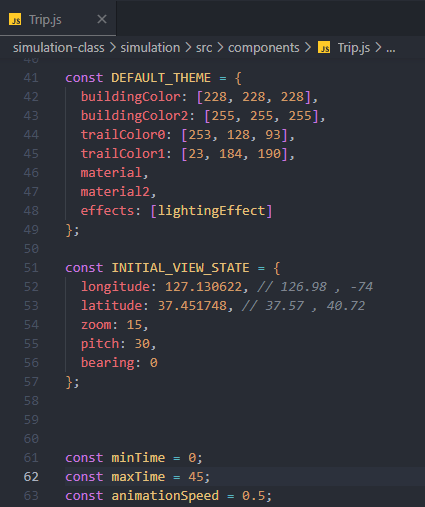

과제 할때 simulation-class/smulation/src/components/Trips.json에 들가면 maxTime 최소 350이상으로 설정하기

longitude = 127.135840
latitude = 37.442836
로 설정하기